In [1]:
# importing essentials
import numpy as np
import pandas as pd

# to make sure we use tensorflow as our backend, so the image format will be depth/channel last
from keras import backend as K
K.set_image_dim_ordering('tf')
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
import numpy as np
from random import shuffle
from tqdm import tqdm

C:\Users\DELL\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
TRAIN_DIR = 'E:/full stack python/Traine_DATA/Traine_DATA'
# TRAIN_DIR = 'C:/Users/DELL/SkyDrive/Documents/data2/train_data'
# TEST_DIR = 'J:/SONGS/LAP DOWNLOAD/GEETA/Compressed/Data of saudia/tes'
TEST_DIR = 'E:/full stack python/Test_DATA/Test_DATA'
# TEST_DIR = 'C:/Users/DELL/SkyDrive/Documents/data2/test_data'
IMG_SIZE = 50

In [3]:
def label_img(img):
    word_label = img.split('.')#[-3]
    s=word_label[0]
 # DIY One hot encoder
    if 'appy' in s : 
        return [1, 0, 0, 0]
    elif 'sad' in  s: 
        return [0, 1, 0, 0]
    elif 'ngry' in  s: 
        return [0, 0, 1, 0] 
    elif (('ormal' in  s ) or ('eutral' in  s)): 
        return [0, 0, 0, 1] 

In [4]:
training_data = []
 
    # tqdm is only used for interactive loading
    # loading the training data
for img in tqdm(os.listdir(TRAIN_DIR)):

    # labeling the images
    label = label_img(img)

    path = os.path.join(TRAIN_DIR, img)

    # loading the image from the path and then converting them into
    # greyscale for easier covnet prob
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    # resizing the image for processing them in the covnet
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # final step-forming the training data list with numpy array of the images
    training_data.append([np.array(img), np.array(label)])

# shuffling of the training data to preserve the random state of our data
shuffle(training_data)

100%|█████████████████████████████████████| 1228/1228 [00:11<00:00, 108.01it/s]


In [5]:
split_value=int(len(training_data) * .3) # 30 /70 split 
train = training_data[:-split_value]
test = training_data[-split_value:]


In [6]:
train_features = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
train_labels = np.array([i[1] for i in train])
val_features = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
val_labels = np.array([i[1] for i in test])

In [7]:
print('x: ', train_features.shape)
print('Y: ', train_labels.shape)
print('test_x shape: ', val_features.shape)
print('test_y shape: ', val_labels.shape)

x:  (860, 50, 50, 1)
Y:  (860, 4)
test_x shape:  (368, 50, 50, 1)
test_y shape:  (368, 4)


In [8]:
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, Dropout
from keras.models import Model, load_model
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
def get_model(input_shape):
    
    drop = 0.3
    
    X_input = Input(input_shape)
    
    X = Conv2D(64, (5,5), strides=(1,1), activation='relu', 
               kernel_initializer='glorot_normal')(X_input)
    X = MaxPooling2D((2,2))(X)
    
    X = Conv2D(128, (5,5), strides=(1,1), activation='relu',
              kernel_initializer='glorot_normal')(X)
    
    X = MaxPooling2D((2,2))(X)
    
    X = Flatten()(X)
    
    X = Dense(256, activation='relu')(X)
    X = Dropout(drop)(X)
    
    X = Dense(32, activation='relu')(X)
    X = Dropout(drop)(X)
    
    X = Dense(4, activation='softmax')(X)
    
    model = Model(inputs=[X_input], outputs=[X])
    
    
    # another model
#     model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
#     model.add(Conv2D(32, (3, 3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))
 
#     model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
#     model.add(Conv2D(64, (3, 3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))
 
#     model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
#     model.add(Conv2D(64, (3, 3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))
 
#     model.add(Flatten())
#     model.add(Dense(512, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(4, activation='softmax'))
    
    
    return model

In [9]:
from keras.optimizers import Nadam
opt = Nadam(lr=0.001)

In [10]:
model = get_model((50, 50, 1))
# compile the model
# model = get_model((train_features))
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
from keras.callbacks import ModelCheckpoint
# only save the best model
f_path = 'modelf.h5'
msave = ModelCheckpoint(f_path, save_best_only=True)

In [12]:
epochs = 25
batch_size = 64
training = model.fit(train_features, train_labels,
                     validation_data=(val_features, val_labels),
                     epochs=epochs,
                     callbacks=[msave],
                     batch_size=batch_size, 
                     verbose=1)

Train on 860 samples, validate on 368 samples
Epoch 1/25
860/860 [==============================] - ETA: 24s - loss: 5.9643 - acc: 0.29 - ETA: 21s - loss: 7.5712 - acc: 0.32 - ETA: 18s - loss: 8.4828 - acc: 0.30 - ETA: 16s - loss: 9.3535 - acc: 0.28 - ETA: 14s - loss: 9.8934 - acc: 0.27 - ETA: 12s - loss: 9.8985 - acc: 0.29 - ETA: 10s - loss: 10.1947 - acc: 0.287 - ETA: 9s - loss: 10.4945 - acc: 0.279 - ETA: 7s - loss: 10.4507 - acc: 0.28 - ETA: 5s - loss: 10.4156 - acc: 0.29 - ETA: 4s - loss: 10.3868 - acc: 0.30 - ETA: 2s - loss: 10.3740 - acc: 0.30 - ETA: 0s - loss: 10.3154 - acc: 0.30 - 26s 30ms/step - loss: 10.3881 - acc: 0.3035 - val_loss: 10.9309 - val_acc: 0.3207
Epoch 2/25
860/860 [==============================] - ETA: 20s - loss: 10.0987 - acc: 0.343 - ETA: 18s - loss: 10.1558 - acc: 0.328 - ETA: 17s - loss: 9.7364 - acc: 0.333 - ETA: 15s - loss: 8.9643 - acc: 0.30 - ETA: 13s - loss: 7.6528 - acc: 0.27 - ETA: 12s - loss: 6.7611 - acc: 0.27 - ETA: 10s - loss: 5.9838 - acc: 0.3

Epoch 14/25
860/860 [==============================] - ETA: 24s - loss: 0.6087 - acc: 0.75 - ETA: 22s - loss: 0.5208 - acc: 0.79 - ETA: 19s - loss: 0.5256 - acc: 0.81 - ETA: 17s - loss: 0.5083 - acc: 0.81 - ETA: 15s - loss: 0.5075 - acc: 0.83 - ETA: 13s - loss: 0.4932 - acc: 0.84 - ETA: 11s - loss: 0.4886 - acc: 0.84 - ETA: 9s - loss: 0.4858 - acc: 0.8359 - ETA: 7s - loss: 0.4709 - acc: 0.835 - ETA: 5s - loss: 0.4649 - acc: 0.834 - ETA: 4s - loss: 0.4616 - acc: 0.833 - ETA: 2s - loss: 0.4647 - acc: 0.826 - ETA: 0s - loss: 0.4751 - acc: 0.823 - 26s 30ms/step - loss: 0.4745 - acc: 0.8233 - val_loss: 1.2357 - val_acc: 0.6005
Epoch 15/25
860/860 [==============================] - ETA: 20s - loss: 0.3456 - acc: 0.85 - ETA: 18s - loss: 0.3818 - acc: 0.84 - ETA: 17s - loss: 0.3786 - acc: 0.84 - ETA: 15s - loss: 0.4138 - acc: 0.85 - ETA: 13s - loss: 0.4316 - acc: 0.84 - ETA: 12s - loss: 0.4196 - acc: 0.84 - ETA: 10s - loss: 0.4266 - acc: 0.84 - ETA: 8s - loss: 0.4108 - acc: 0.8516 - ETA: 7s - 

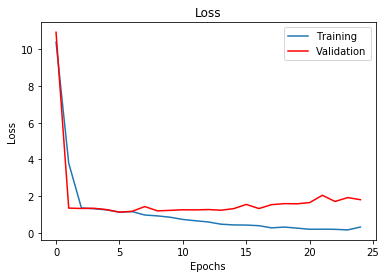

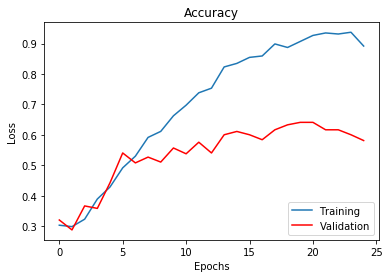

In [13]:
loss = training.history['loss']
val_loss = training.history['val_loss']
acc = training.history['acc']
val_acc = training.history['val_acc']

# loss plot
tra = plt.plot(loss)
val = plt.plot(val_loss, 'r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend(["Training", "Validation"])

plt.show()

# accuracy plot
plt.plot(acc)
plt.plot(val_acc, 'r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Accuracy')
plt.legend(['Training', 'Validation'], loc=4)
plt.show()

In [16]:
testing_data = []
for img in tqdm(os.listdir(TEST_DIR)):
#     path = os.path.join(TEST_DIR, img)
#     img_num = img.split('.')[0]
#     img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
#     img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
#     testing_data.append([np.array(img), img_num])
    
    
    
    label = label_img(img)

    path = os.path.join(TEST_DIR, img)

    # loading the image from the path and then converting them into
    # greyscale for easier covnet prob
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    # resizing the image for processing them in the covnet
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # final step-forming the training data list with numpy array of the images
    testing_data.append([np.array(img), np.array(label)])

         
shuffle(testing_data)

100%|███████████████████████████████████████| 299/299 [00:02<00:00, 114.00it/s]


In [17]:
test_features = np.array([i[0] for i in testing_data]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_labels = np.array([i[1] for i in testing_data])
# test_labels = np.argmax(test_labels, axis=1)
print('x: ', test_features.shape)
print('Y: ', test_labels.shape)

x:  (299, 50, 50, 1)
Y:  (299, 4)


In [18]:
from sklearn import metrics
Predicted_label = []
Label_OF_test_data=[]
print("pred")
pred = model.predict(test_features)#, batch_size=batch_size, verbose=1)
# print(pred)
for val in pred:
    if np.argmax(val) == 0:
#         str_label ='Happy'
        Predicted_label.append(0)
    elif np.argmax(val) == 1:
#         str_label ='sad'
        Predicted_label.append(1)
    elif np.argmax(val) == 2:
#         str_label ='Angry'
        Predicted_label.append(2)
    elif np.argmax(val) == 3:
#         str_label ='normal'
        Predicted_label.append(3)
for val in test_labels:
    if np.argmax(val) == 0:
#         str_label ='Happy'
        Label_OF_test_data.append(0)
    elif np.argmax(val) == 1:
#         str_label ='sad'
        Label_OF_test_data.append(1)
    elif np.argmax(val) == 2:
#         str_label ='Angry'
        Label_OF_test_data.append(2)
    elif np.argmax(val) == 3:
#         str_label ='normal'
        Label_OF_test_data.append(3)
    
    
    
    
score=metrics.accuracy_score(Label_OF_test_data, Predicted_label)
print(Label_OF_test_data)
print(Predicted_label)
print('Accuracy cnn : {}'.format(score))
# convert predicions from categorical back to 0...9 digits
# pred_digits = np.argmax(pred, axis=1)
# print(pred_digits)

# score=metrics.accuracy_score(test_labels, pred_digits)
# print(Label_OF_test_data)
# print(Predicted_label)
# print('Accuracy cnn : {}'.format(score))

pred
[1, 2, 2, 2, 1, 1, 1, 0, 1, 0, 0, 3, 1, 0, 0, 3, 1, 0, 3, 2, 2, 1, 3, 0, 3, 0, 1, 1, 0, 1, 0, 1, 2, 1, 2, 2, 3, 0, 2, 2, 1, 0, 2, 1, 2, 0, 2, 0, 3, 1, 0, 3, 0, 3, 0, 3, 3, 2, 2, 1, 1, 3, 0, 1, 1, 0, 1, 2, 0, 2, 0, 2, 3, 2, 0, 0, 2, 3, 1, 1, 2, 2, 1, 0, 0, 0, 2, 3, 3, 0, 3, 0, 0, 3, 1, 1, 3, 1, 3, 3, 0, 1, 3, 0, 1, 1, 3, 2, 2, 0, 2, 1, 0, 3, 1, 3, 2, 0, 3, 3, 0, 1, 2, 1, 3, 3, 2, 2, 3, 2, 3, 1, 2, 2, 0, 0, 0, 3, 3, 3, 0, 1, 3, 2, 1, 3, 2, 2, 2, 0, 3, 3, 3, 1, 3, 3, 3, 0, 1, 2, 1, 0, 2, 3, 2, 2, 0, 2, 1, 1, 3, 1, 1, 3, 3, 3, 1, 0, 1, 1, 3, 3, 0, 2, 3, 0, 3, 3, 0, 3, 0, 3, 1, 2, 2, 2, 3, 3, 1, 1, 2, 0, 2, 3, 0, 3, 1, 3, 1, 1, 0, 2, 0, 0, 0, 3, 1, 1, 0, 2, 1, 2, 1, 2, 3, 3, 2, 2, 1, 0, 0, 0, 2, 2, 0, 3, 0, 2, 1, 1, 1, 3, 1, 2, 3, 2, 0, 3, 2, 1, 3, 0, 2, 3, 3, 3, 2, 0, 2, 2, 3, 3, 3, 3, 0, 0, 2, 2, 0, 1, 2, 0, 3, 3, 2, 1, 2, 2, 1, 1, 1, 2, 0, 0, 1, 0, 3, 2, 2, 2, 3, 2, 3, 0, 1, 0, 2, 0, 0]
[1, 0, 1, 2, 1, 1, 1, 0, 1, 3, 0, 2, 0, 3, 3, 0, 1, 0, 3, 2, 1, 1, 2, 3, 0, 0, 1, 1, 3, 0, 0, 1, 

In [59]:
from sklearn import metrics
import matplotlib.pyplot as plt
# if you need to create the data:
# test_data = process_test_data()
# if you already have some saved:
# test_data = np.load('test_data.npy')
 
# fig = plt.figure()
Label_OF_test_data = [] 
Predicted_label = []
Predicted_label_RandomForest = []
b = True


for num, data in enumerate(testing_data):
    # cat: [1, 0]
    # dog: [0, 1]
     
    img_num = data[1]
    img_data = data[0]
#     print(img_num)
    if 'happy' in img_num : 
        Label_OF_test_data.append(0)
    elif 'sad' in  img_num: 
        Label_OF_test_data.append(1)
    elif 'angry' in  img_num: 
        Label_OF_test_data.append(2)
    elif 'normal' in  img_num: 
        Label_OF_test_data.append(3)
        
    
#     y = fig.add_subplot(4, 5, num + 1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
 
    # model_out = model.predict([data])[0]
#     print(data.shape)
#     print(data.ndim)
    
#     dataRC=data.reshape(1,IMG_SIZE*IMG_SIZE)
#     print(dataRC.shape)
#     print(dataRC.ndim)
#     if b:
#         break
    model_out = model.predict([data])[0]
#     print(np.argmax(model_out))
    if np.argmax(model_out) == 0:
#         str_label ='Happy'
        Predicted_label.append(0)
    elif np.argmax(model_out) == 1:
#         str_label ='sad'
        Predicted_label.append(1)
    elif np.argmax(model_out) == 2:
#         str_label ='Angry'
        Predicted_label.append(2)
    elif np.argmax(model_out) == 3:
#         str_label ='normal'
        Predicted_label.append(3)
    
        

score=metrics.accuracy_score(Label_OF_test_data, Predicted_label)
print(Label_OF_test_data)
print(Predicted_label)
print('Accuracy cnn : {}'.format(score))

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


ValueError: Error when checking : expected input_2 to have 4 dimensions, but got array with shape (28, 28, 1)